In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.optimizers import AdamW
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten, MaxPooling3D


2024-02-18 13:13:32.586557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 13:13:32.586650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 13:13:32.714142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of images in the train set :  11200
Number of images in the test set ;  1400
Number of images in prediction set :  4


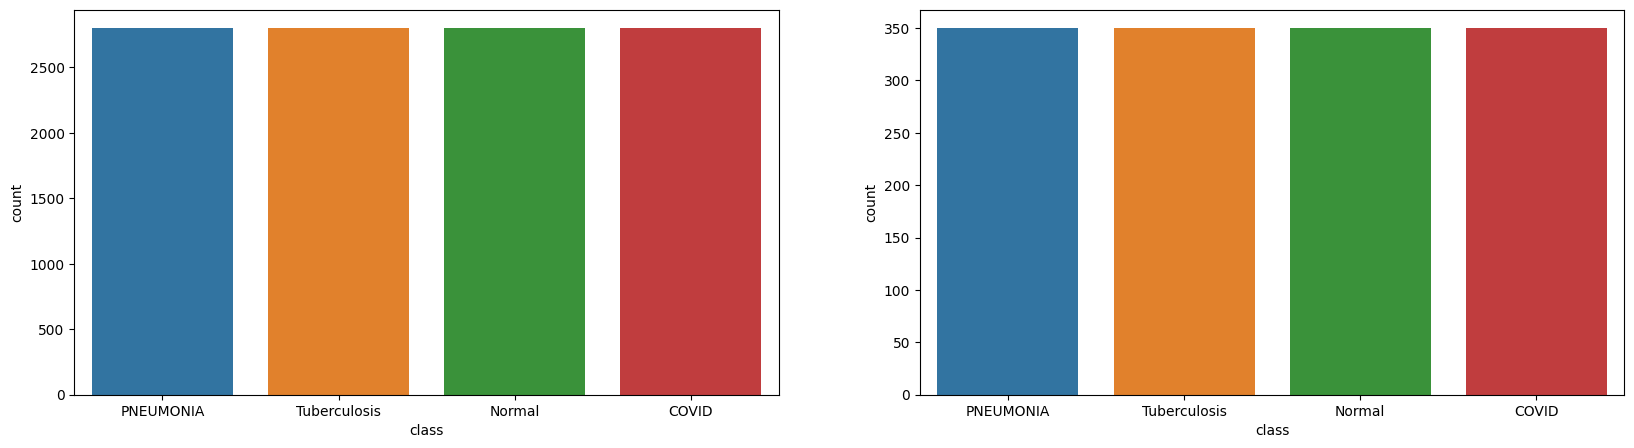

In [2]:
root_path = '/kaggle/input/hiiukoi/Chess-Splitted/'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = '/kaggle/input/hiiukoi/Chess-Splitted/train/' #one more seg_train folder within
seg_test_folders = '/kaggle/input/hiiukoi/Chess-Splitted/test/'
seg_pred_folders = '/kaggle/input/hiiukoi/Chess-Splitted/val/'
quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders+folder))

for folder in os.listdir(seg_test_folders):
    quantity_te[folder] = len(os.listdir(seg_test_folders+folder))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))
number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in prediction set : ",number_of_images_in_prediction_set)

plt.show()


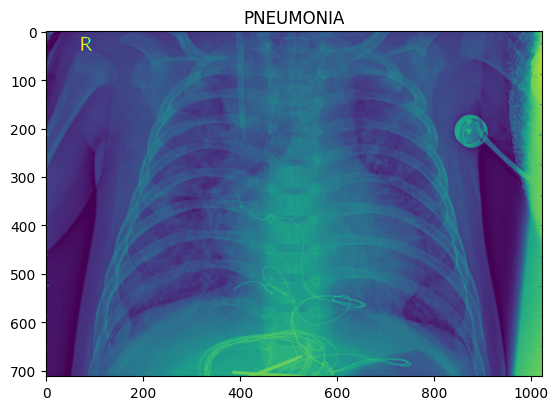

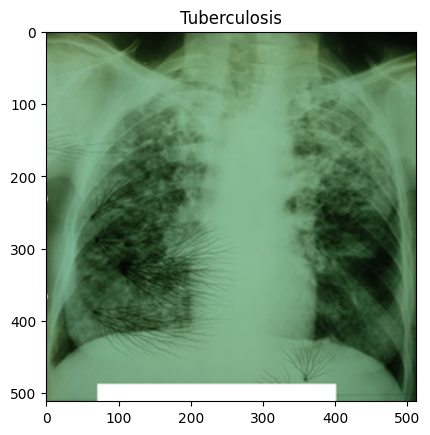

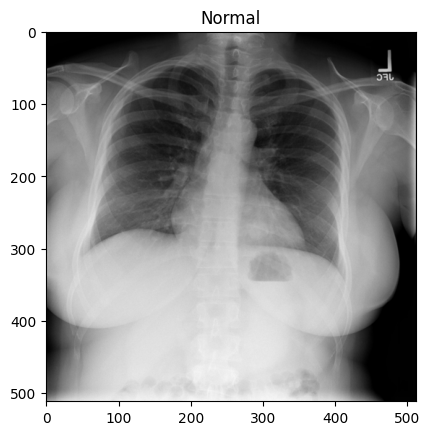

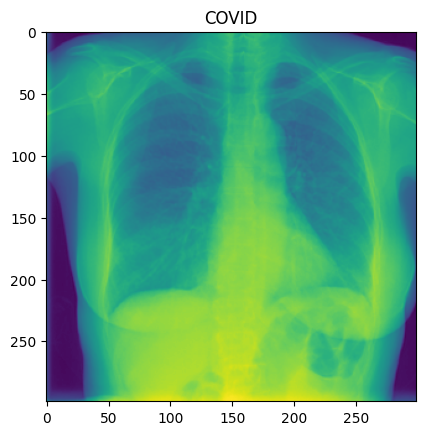

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# specify the directory you want to use
directory = '/kaggle/input/hiiukoi/Chess-Splitted/train'

for foldername in os.listdir(directory):
    if os.path.isdir(os.path.join(directory, foldername)):
        for filename in os.listdir(os.path.join(directory, foldername)):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                img = mpimg.imread(os.path.join(directory, foldername, filename))
                plt.figure()
                plt.imshow(img)
                plt.title(foldername)
                plt.show()
                break


# **VGG16**

In [4]:
img_width, img_height=224,224


In [5]:
from keras.applications.vgg16 import preprocess_input


data_dir = '/kaggle/input/hiiukoi/Chess-Splitted'
# Preprocess training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input  # Function to preprocess images for ResNet-50
)

val_datagen = ImageDataGenerator(rescale=1.0/255, preprocessing_function=preprocess_input)

# Load training and validation data using data generators
train_generator = train_datagen.flow_from_directory(
    data_dir + '/train',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    data_dir + '/val',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

Found 11200 images belonging to 4 classes.
Found 1400 images belonging to 4 classes.


In [6]:
# Define the input shape
img_width, img_height = 224, 224

# Load the VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of VGG16 model
for layer in vgg_model.layers:
    layer.trainable = False

x=vgg_model.output
x=MaxPooling2D()(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.5)(x)
x=Flatten()(x)
output=Dense(4,activation='softmax')(x)
model=Model(inputs=vgg_model.inputs,outputs=output)  # Assuming 4 classes for classification



# Compile the model with Adam optimizer
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 2s 0us/step


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('vgg_best.h5', monitor='val_loss', save_best_only=True)

In [9]:
callbacks = [reduce_lr, early_stopping, checkpoint]

In [10]:
model.fit(train_generator,
          epochs=50,
          callbacks=callbacks,
          validation_data=val_generator,
         )

Epoch 1/50


2024-02-18 13:13:59.408374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708262046.836936      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350/350 [==============================] - 242s 669ms/step - loss: 0.5562 - accuracy: 0.7864 - val_loss: 0.4325 - val_accuracy: 0.8264 - lr: 0.0010
Epoch 2/50


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


350/350 [==============================] - 168s 479ms/step - loss: 0.3856 - accuracy: 0.8521 - val_loss: 0.2912 - val_accuracy: 0.8979 - lr: 0.0010
Epoch 3/50
350/350 [==============================] - 168s 481ms/step - loss: 0.3339 - accuracy: 0.8729 - val_loss: 0.4609 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 4/50
350/350 [==============================] - 168s 479ms/step - loss: 0.2993 - accuracy: 0.8867 - val_loss: 0.2675 - val_accuracy: 0.8964 - lr: 0.0010
Epoch 5/50
350/350 [==============================] - 167s 476ms/step - loss: 0.2849 - accuracy: 0.8941 - val_loss: 0.2253 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 6/50
350/350 [==============================] - 165s 470ms/step - loss: 0.2683 - accuracy: 0.8976 - val_loss: 0.3244 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 7/50
350/350 [==============================] - 167s 477ms/step - loss: 0.2517 - accuracy: 0.9057 - val_loss: 0.2706 - val_accuracy: 0.9021 - lr: 0.0010
Epoch 8/50
350/350 [==============================] - 164

# **ResNet50**

In [11]:
from keras.applications.resnet50 import preprocess_input
data_dir = '/kaggle/input/hiiukoi/Chess-Splitted'
# Preprocess training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input  # Function to preprocess images for ResNet-50
)

val_datagen = ImageDataGenerator(rescale=1.0/255, preprocessing_function=preprocess_input)

# Load training and validation data using data generators
train_generator = train_datagen.flow_from_directory(
    data_dir + '/train',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    data_dir + '/val',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

Found 11200 images belonging to 4 classes.
Found 1400 images belonging to 4 classes.


In [12]:

resnet = ResNet50(input_shape=(224,224,3),weights='imagenet', include_top=False)
for layer in resnet.layers:
    layer.trainable = True

94765736/94765736 [==============================] - 3s 0us/step


In [13]:
from tensorflow.keras import regularizers
z=resnet.output
z=MaxPooling2D()(z)
z=Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.03))(z)
z=Dropout(0.1)(z)
z=Flatten()(z)
output3=Dense(4,activation='softmax')(z)
model=Model(inputs=resnet.inputs,outputs=output3)

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [15]:
model.compile(optimizer='SGD',loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('vgg_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [reduce_lr, early_stopping, checkpoint]

In [17]:
model.fit(train_generator,
          epochs=50,
          callbacks=callbacks,
          validation_data=val_generator,
         )

Epoch 1/50


2024-02-18 15:03:08.941223: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


350/350 [==============================] - 192s 493ms/step - loss: 20.6628 - accuracy: 0.8521 - val_loss: 18.6560 - val_accuracy: 0.2500 - lr: 0.0100
Epoch 2/50
350/350 [==============================] - 168s 481ms/step - loss: 13.3543 - accuracy: 0.9469 - val_loss: 13.4329 - val_accuracy: 0.3171 - lr: 0.0100
Epoch 3/50
350/350 [==============================] - 169s 484ms/step - loss: 8.7821 - accuracy: 0.9650 - val_loss: 7.9189 - val_accuracy: 0.6736 - lr: 0.0100
Epoch 4/50
350/350 [==============================] - 167s 477ms/step - loss: 5.7928 - accuracy: 0.9723 - val_loss: 4.8517 - val_accuracy: 0.9179 - lr: 0.0100
Epoch 5/50
350/350 [==============================] - 167s 478ms/step - loss: 3.8212 - accuracy: 0.9784 - val_loss: 3.1671 - val_accuracy: 0.9486 - lr: 0.0100
Epoch 6/50
350/350 [==============================] - 171s 487ms/step - loss: 2.5243 - accuracy: 0.9854 - val_loss: 2.0471 - val_accuracy: 0.9836 - lr: 0.0100
Epoch 7/50
350/350 [==============================] -

# **InceptionV3**

In [18]:
from keras.applications.inception_v3 import preprocess_input
data_dir = '/kaggle/input/hiiukoi/Chess-Splitted'
# Preprocess training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input  # Function to preprocess images for ResNet-50
)

val_datagen = ImageDataGenerator(rescale=1.0/255, preprocessing_function=preprocess_input)

# Load training and validation data using data generators
train_generator = train_datagen.flow_from_directory(
    data_dir + '/train',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    data_dir + '/val',
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical'
)

Found 11200 images belonging to 4 classes.
Found 1400 images belonging to 4 classes.


In [19]:
inception=InceptionV3(include_top=False,input_shape=(224,224,3),weights='imagenet')
for layer in inception.layers:
    layer.trainable = True

87910968/87910968 [==============================] - 3s 0us/step


In [20]:
from tensorflow.keras import regularizers
z=inception.output
z=MaxPooling2D()(z)
z=Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.03))(z)
z=Dropout(0.1)(z)
z=Flatten()(z)
output3=Dense(4,activation='softmax')(z)
model=Model(inputs=inception.inputs,outputs=output3)

In [21]:
from keras.optimizers import RMSprop
model.compile(optimizer=SGD(lr=0.0001, momentum=0.85),loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint = ModelCheckpoint('vgg_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [reduce_lr, early_stopping, checkpoint]

In [23]:
model.fit(train_generator,
          epochs=50,
          callbacks=callbacks,
          validation_data=val_generator,
         )

Epoch 1/50


2024-02-18 17:27:54.043319: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


350/350 [==============================] - 207s 529ms/step - loss: 9.0110 - accuracy: 0.8293 - val_loss: 3.1562 - val_accuracy: 0.2686 - lr: 0.0100
Epoch 2/50
350/350 [==============================] - 179s 510ms/step - loss: 0.7094 - accuracy: 0.9328 - val_loss: 0.6628 - val_accuracy: 0.8307 - lr: 0.0100
Epoch 3/50
350/350 [==============================] - 181s 517ms/step - loss: 0.1936 - accuracy: 0.9523 - val_loss: 0.3647 - val_accuracy: 0.8886 - lr: 0.0100
Epoch 4/50
350/350 [==============================] - 179s 510ms/step - loss: 0.1358 - accuracy: 0.9637 - val_loss: 0.2655 - val_accuracy: 0.9050 - lr: 0.0100
Epoch 5/50
350/350 [==============================] - 179s 512ms/step - loss: 0.1105 - accuracy: 0.9697 - val_loss: 0.2475 - val_accuracy: 0.9207 - lr: 0.0100
Epoch 6/50
350/350 [==============================] - 179s 512ms/step - loss: 0.0888 - accuracy: 0.9754 - val_loss: 0.5304 - val_accuracy: 0.8207 - lr: 0.0100
Epoch 7/50
350/350 [==============================] - 179

# **ENSEMBLE**